# Pricing of CDO Tranches

## Importation of libraries

In [1]:
from library import *

In [2]:
import numpy as np
from matplotlib import pyplot as plt
from concurrent.futures import ProcessPoolExecutor
from tqdm import tqdm
import time

## Importation of parameters

We consider a synthetic collateralized debt obligation (CDO) portfolio composed of $ I = 500 $ homogeneous credit exposures (e.g., mortgages), each with a notional of \$2 million. The reference maturity of the structure is 4 years.

The objective of the analysis is to calibrate a double t-Student copula model to match the tranche prices implied by a Vasicek (Gaussian copula) framework. This calibration focuses on the equity tranche (from 0% to 3%) and compares the resulting model output to market-implied prices across all tranches.

**Market-implied correlations** $ \rho_{\text{mkt}} $ are assumed to be given for each tranche and are used to compute benchmark tranche prices under the Vasicek model. These are:

- $ \rho_{\text{mkt}} = [0.23, 0.26, 0.291, 0.323, 0.355] $

**Tranche definitions:**

- Upper attachment points: $ K_u = [0.03, 0.06, 0.09, 0.12, 0.22] $
- Lower attachment points: $ K_d = [0.00, 0.03, 0.06, 0.09, 0.12] $

The **equity tranche** used for calibration is the one from $ K_d = 0\% $ to $ K_u = 3\% $.

Other input parameters used throughout the analysis are:

- Default probability over 4 years: $ p = 6\% $
- Recovery rate: $ R = 40\% $
- Discount factor (present value): $ \text{DF} = 0.89 $

The goal is to calibrate the degrees of freedom $ \nu $ of the double t-Student copula model such that the price of the equity tranche matches that of the Vasicek model, and to minimize the pricing error (MSE) across all other tranches.

In [7]:
# Market-implied correlations for each tranche
corr_mkt = [0.23, 0.26, 0.291, 0.323, 0.355]

# Upper and lower attachment points
Ku_list = [0.03, 0.06, 0.09, 0.12, 0.22]
Kd_list = [0.00, 0.03, 0.06, 0.09, 0.12]

# Calibration parameters
Kd_calibration = 0.0         # Equity tranche lower bound
p = 0.06                     # 4-year default probability
notional = 2e6               # Notional per mortgage
I = 500                      # Number of exposures
recovery = 0.4               # Recovery rate
discount = 0.89

## Calibration of the correlation

In this analysis, we calibrate the degrees of freedom parameter $ \nu $ of the double t-Student copula model.  
The goal is to match the price of the **equity tranche** $[0, 3 \%]$ under the t-Student model to the price inferred from a Vasicek (Gaussian copula) model.

We define:

- $ p_{\text{LHP}}^{\text{mkt}} $: market-implied price of the equity tranche (from the Vasicek model),
- $ p_{\text{LHP}}^{t}(\nu, \rho) $: equity tranche price under the t-Student model, for given $ \nu $ and $ \rho $,
- $ \rho^*(\nu) $: correlation parameter **calibrated for each $ \nu $** such that  
  $ p_{\text{LHP}}^{t}(\nu, \rho^*(\nu)) = p_{\text{LHP}}^{\text{mkt}} $.  
  This calibration step ensures that the t-Student model exactly reproduces the equity tranche price.

Once $ \rho^*(\nu) $ is calibrated, we compute the prices of the **other tranches** under the t-Student model using this pair $ (\nu, \rho^*(\nu)) $, and compare them to the corresponding Vasicek-based prices.

Let:

- $ p_j^{t}(\nu, \rho^*(\nu)) $: price of tranche $ j $ under the t-Student model,
- $ p_j^{\text{mkt}} $: corresponding Vasicek-based price of tranche $ j $,
- $ I $: number of non-equity tranches (used for error computation only).

The **mean squared error (MSE)** on tranche prices (excluding equity) is defined as:  
$ \text{MSE}(\nu) = \frac{1}{I} \sum_{j=1}^{I} \left( p_j^{t}(\nu, \rho^*(\nu)) - p_j^{\text{mkt}} \right)^2 $

The optimal degrees of freedom $ \nu^* $ is then selected by minimizing this pricing error:  
$ \nu^* = \arg\min_{\nu} \text{MSE}(\nu) $

**Important:** the calibration process is based purely on **tranche prices**, and not on matching or minimizing differences in the correlation values across models.

In [11]:
MSE_min, rho_model, idx_min, nu_list, MSE_list = calibration_freedom_t_student_LHP_optimized(discount, corr_mkt, Kd_calibration, Ku_list,
                                       recovery, p,'off')

100%|██████████| 24/24 [03:11<00:00,  7.97s/it]


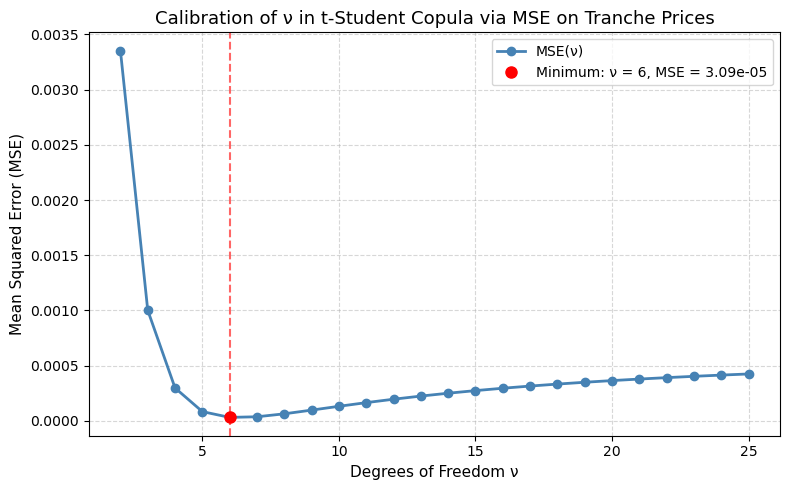

In [17]:
title = 'Calibration of ν in t-Student Copula via MSE on Tranche Prices'

plot_mse(np.arange(2,26), MSE_list,title)

$$
\begin{array}{|c|c|c|}
\hline
\mathbf{\nu} & \mathbf{\rho^*} & \mathbf{MSE} \\
\hline
6 & 0.32 & 3.1e-5 \\
\hline
\end{array}
$$

## Prices of CDO Tranches : Equity Tranche, Junior Mezannine Tranche and Senior Mezannine Tranche with a Double-t-Student Model


In this section, we compute and compare the prices of various tranches of a synthetic Collateralized Debt Obligation (CDO) under a double t-Student copula framework. Specifically, we focus on:

- the **Equity tranche**: $[0\%, 3\%]$
- the **Cumulative Junior Mezzanine tranche**: $[0\%, 6\%]$
- the **Cumulative Senior Mezzanine tranche**: $[0\%, 9\%]$

We evaluate the price of each tranche using three different methods:

### 1. HP Price (Heterogeneous Pool)
The HP price is computed via a **semi-analytical integration** of the conditional loss distribution under the t-Student copula model. It captures the full dependence structure and is considered the most accurate (but also most computationally intensive) approach.

### 2. KL Approximation (Kullback–Leibler)
The KL approximation relies on a **large deviations approximation** of the conditional default distribution. For a given number of exposures $I$, it approximates the loss distribution using a saddlepoint method:

$$
\mathbb{E}[\text{loss}] \approx \int_{-\infty}^{\infty} \left( \int_0^1 C(z) \exp(-I \cdot \text{KL}(z, p(y))) \cdot \ell(z) \,dz \right) f_Y(y) \,dy
$$

where $C(z)$ is a normalization term, $\ell(z)$ is the tranche loss function, and $\text{KL}(z, p(y))$ is the Kullback–Leibler divergence between $z$ and the conditional default probability $p(y)$.

### 3. LHP Price (Large Homogeneous Portfolio, Vasicek)
This price assumes an **infinite portfolio approximation** with a Gaussian one-factor copula (Vasicek model). It provides a simple closed-form expression for the expected tranche loss:

$$
\text{EL}_{\text{LHP}} = \int_{-\infty}^{\infty} \ell\left( F^{-1}_{\text{loss}}(y) \right) \phi(y) \, dy
$$

In [22]:
I_list = np.round(np.linspace(1,1000,25))
nu_optimal = idx_min+2

### Homegeneous Portfolio Prices

In [25]:
start_time = time.time()
HP_prices = tranche_prices_double_t_optimized(nu_optimal, I_list, Kd_calibration, Kd_list, Ku_list, recovery, rho_model, p, discount, 0)
end_time = time.time()

print(f"Execution time of : {end_time - start_time:.2f} seconds")

Execution time of : 29.93 seconds


### Kullback-Leibler Approximation Prices

In [27]:
start_time = time.time()

KL_prices = tranche_prices_double_t_optimized(nu_optimal, I_list, Kd_calibration, Kd_list, Ku_list[:3], recovery, rho_model, p, discount, 1)

end_time = time.time()

print(f"Execution time of : {end_time - start_time:.2f} seconds")

Execution time of : 3.24 seconds


### Large Homogeneous Portfolio Prices

In [29]:
start_time = time.time()

LHP_prices = tranche_prices_double_t_optimized(nu_optimal, I_list, Kd_calibration, Kd_list, Ku_list[:3], recovery, rho_model, p, discount, 2)

end_time = time.time()

print(f"Execution time of : {end_time - start_time:.2f} seconds")

Execution time of : 5.47 seconds


### Plot of the prices 

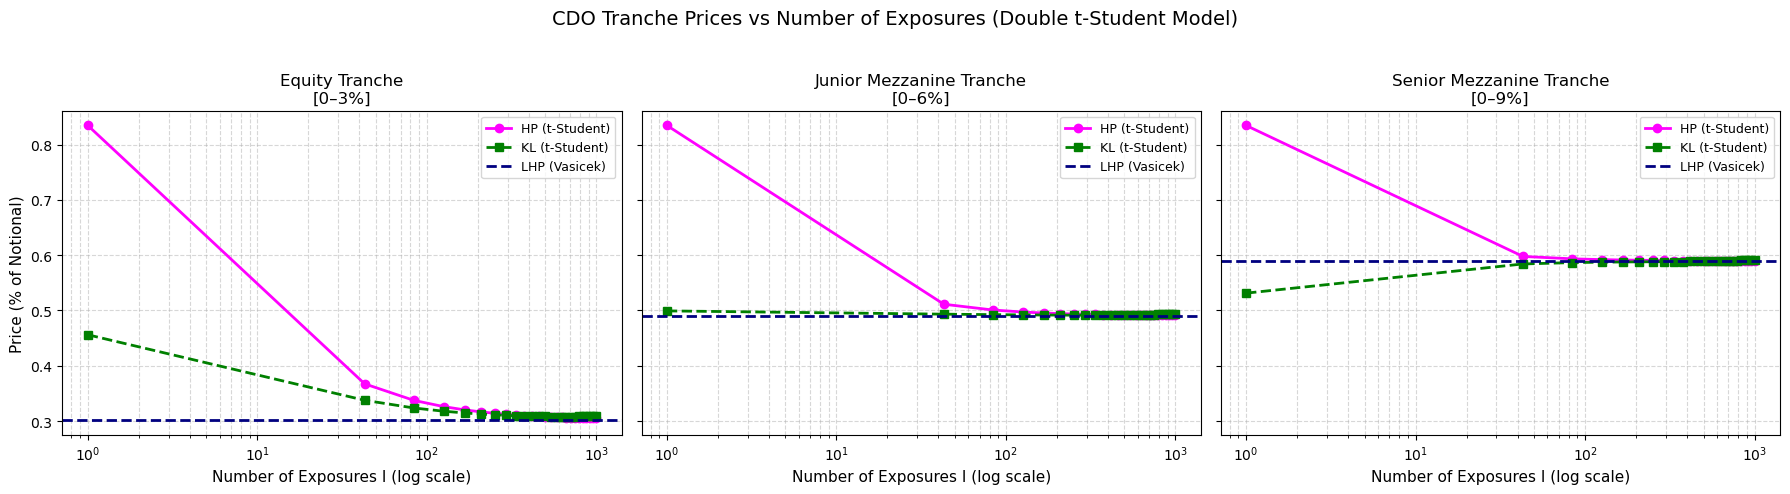

In [31]:
plot_tranche_prices_vs_I(I_list, HP_prices, KL_prices, LHP_prices, Ku_list)

The figure illustrates the evolution of the price of a given CDO tranche as a function of the number of exposures $I$ on a logarithmic scale, under the three pricing methods explained before.

We observe the following behavior:

- As the number of exposures $I$ increases, the HP and KL prices converge toward the LHP benchmark.
- For small $I$ (e.g. $I = 1$ or $I < 10$), the HP price is significantly higher than both the KL and LHP prices. This reflects the **high granularity** and **discrete loss distribution** in small portfolios.
- The KL approximation systematically **underestimates the HP price**, especially when $I$ is small. This is expected, as KL is an asymptotic method designed for large $I$ and assumes a smooth saddlepoint approximation of the loss distribution.
- The LHP price remains constant, as it assumes an infinite portfolio. It serves as a benchmark target that both HP and KL approach when $I \rightarrow \infty$.

In conclusion, this plot clearly shows the **importance of accounting for portfolio size** in tranche pricing. The HP method is the most accurate but computationally expensive; KL provides a fast and reasonable approximation for $I \gtrsim 50$; and the LHP model can be used only when the portfolio is large enough to justify the infinite pool assumption.

## Kullback-Leibler Calibration of the correlation

In this analysis, we now calibrate the degrees of freedom parameter $ \nu $ of the double t-Student copula model.  
The goal is to match the price of the **equity tranche** $[K_d, K_{u,0}]$ under the t-Student model (computed using the KL approximation) to the price inferred from a Vasicek (Gaussian copula) model.

We define:

- $ p_{\text{LHP}}^{\text{mkt}} $: market price of the equity tranche (from the Vasicek model),
- $ p_{\text{KL}}^{\text{t-student}}(\nu, \rho) $: equity tranche price under the **t-Student KL approximation**, for given $ \nu $ and $ \rho $,
- $ \rho^*(\nu) $: correlation parameter **calibrated for each $ \nu $** such that  
  $ p_{\text{KL}}^{\text{t-student}}(\nu, \rho^*(\nu)) = p_{\text{LHP}}^{\text{mkt}}$.  
  This calibration step ensures that the KL-based pricing of the equity tranche matches the market-implied value.

Once $ \rho^*(\nu) $ is calibrated, we compute the prices of the **other tranches** using the KL approximation under this pair $ (\nu, \rho^*(\nu)) $, and compare them to the corresponding Vasicek-based prices.

Let:

- $ p_j^{\text{KL}}(\nu, \rho^*(\nu)) $: KL-approximated price of tranche $ j $ under the t-Student model,
- $ p_j^{\text{mkt}} $: corresponding Vasicek-based price of tranche $ j $,
- $ I $: number of non-equity tranches (used for error computation only).

The **mean squared error (MSE)** on tranche prices (excluding equity) is defined as:  
$$
\text{MSE}(\nu) = \frac{1}{I} \sum_{j=1}^{I} \left( p_j^{\text{KL}}(\nu, \rho^*(\nu)) - p_j^{\text{mkt}} \right)^2
$$

The optimal degrees of freedom $ \nu^* $ is then selected by minimizing this pricing error:  
$$
\nu^* = \arg\min_{\nu} \text{MSE}(\nu)
$$

**Important:** the calibration process is entirely based on **tranche prices computed using the KL approximation**, without relying on full HP computations or correlation calibration beyond equity.

In [39]:
MSE_min_KL, rho_model_KL, idx_min_KL, nu_list_KL, MSE_list_KL = calibration_freedom_t_student_KL_optimized(discount, corr_mkt,I, Kd_calibration, Ku_list,
                                       recovery, p, 'off')

100%|██████████| 24/24 [00:13<00:00,  1.75it/s]


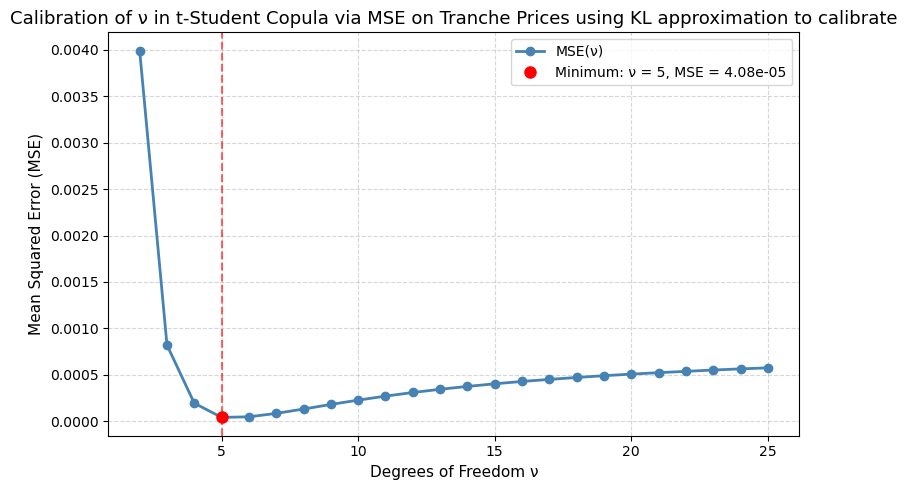

In [40]:
title_KL = 'Calibration of ν in t-Student Copula via MSE on Tranche Prices using KL approximation to calibrate'

plot_mse(np.arange(2,26), MSE_list_KL,title_KL)

$$
\begin{array}{|c|c|c|}
\hline
\mathbf{\nu} & \mathbf{\rho^*} & \mathbf{MSE} \\
\hline
5 & 0.33 & 4.08e-5 \\
\hline
\end{array}
$$

We notice the KL calibration almost leads to the same result than with the LHP one, which is coherent because the KL price when I tends to + infity the KL price tends to the LHP price. Furthermore, this calibration is much more practical and takes much less time than the LHP one.

### Vasicek Prices 

We now want to  compute vasicek prices with the correlation of the market

### HP Prices

In [53]:
start_time = time.time()
HP_vasicek = tranche_prices_vasicek(I_list, Kd_calibration, Kd_list, Ku_list,
                           recovery, corr_mkt[0], p, discount, 0)
end_time = time.time()

print(f"Execution time of : {end_time - start_time:.2f} seconds")

Execution time of : 3.24 seconds


### Kullback-Leibler Prices

In [55]:
start_time = time.time()
KL_vasicek = tranche_prices_vasicek(I_list, Kd_calibration, Kd_list, Ku_list,
                           recovery, corr_mkt[0], p, discount, 1)
end_time = time.time()

print(f"Execution time of : {end_time - start_time:.2f} seconds")

Execution time of : 0.49 seconds


### LHP Prices

In [57]:
start_time = time.time()
LHP_vasicek = tranche_prices_vasicek(I_list, Kd_calibration, Kd_list, Ku_list,
                           recovery, corr_mkt[0], p, discount, 2)
end_time = time.time()

print(f"Execution time of : {end_time - start_time:.2f} seconds")

Execution time of : 0.24 seconds


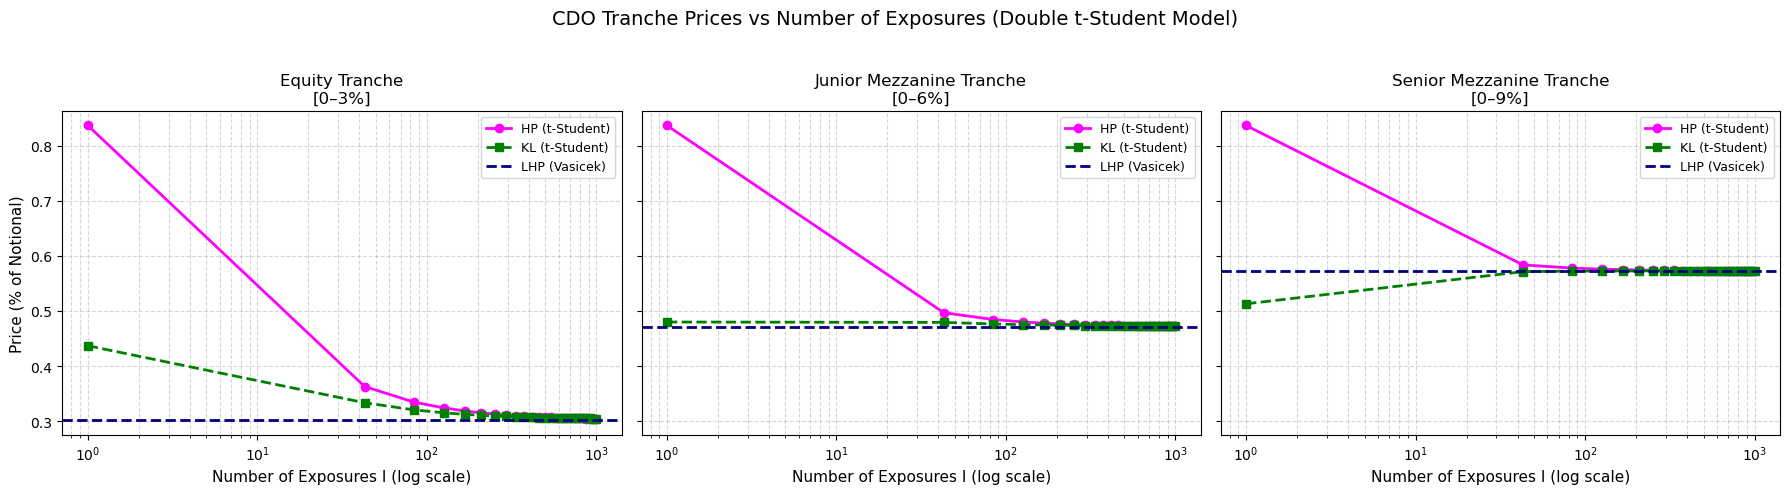

In [58]:
plot_tranche_prices_vs_I(I_list, HP_vasicek, KL_vasicek, LHP_vasicek, Ku_list)

# Copula Simulation

### Gaussian One-Factor Copula – Monte Carlo Pricing of CDO Tranches

This function implements the pricing of cumulative CDO tranches under a **Gaussian one-factor copula** using **Monte Carlo simulation**. It estimates the expected tranche losses and returns discounted prices along with confidence intervals and estimator variances.

#### Inputs:

- `discount` : Discount factor (present value of €1 at maturity).
- `Kd` : Lower attachment point of the tranche (typically 0 for the equity tranche).
- `KuList` : Vector of upper attachment points for each tranche (e.g., `[0.03, 0.06, 0.09]`).
- `Nsim` : Number of Monte Carlo simulations (e.g., 1e5).
- `rho` : Asset correlation parameter $ \rho \in (0,1) $.
- `recovery` : Recovery rate $ R $ of each exposure.
- `pd` : Unconditional default probability $ Q $ over the time horizon.
- `I` : Number of identical loans in the portfolio.

#### Method Overview:

1. **Latent Variable Simulation**  
   For each exposure, the latent variable is simulated using a **one-factor Gaussian structure**:

   $$
   X_{i}^{(n)} = \sqrt{\rho} \cdot Y^{(n)} + \sqrt{1 - \rho} \cdot \varepsilon_{i}^{(n)}
   $$

   - $Y^{(n)}$ is the systemic factor (common to all exposures).
   - $\varepsilon_{i}^{(n)}$ is the idiosyncratic shock for exposure $i$.
   - Default occurs if $X < \Phi^{-1}(p)$.

2. **Default and Loss Calculation**  
   For each simulation $n$, the portfolio loss is computed as:

   $$
   L^{(n)} = \frac{1 - R}{I} \sum_{i=1}^{I} \mathbf{1}\{X_i^{(n)} < K\}
   $$

   where $K = \Phi^{-1}(p)$ is the default threshold.

3. **Cumulative Tranche Payoff**  
   For each upper attachment point $K_u$:

   $$
   \text{Payoff}^{(n)} = \frac{ \max(L^{(n)} - K_d, 0) - \max(L^{(n)} - K_u, 0) }{K_u - K_d}
   $$

   This represents the fraction of the tranche that is lost in simulation $n$.

4. **Monte Carlo Estimation**  
   The expected loss is estimated via the average over all $N$ simulations. Variance and standard error are also computed.

5. **Discounted Tranche Price**  
   The final price is:

   $$
   \text{Price} = \text{DF} \cdot \left(1 - \mathbb{E}[\text{Payoff}]\right)
   $$

   Confidence intervals at $ 95 \% $ are also returned.

#### Outputs:

- `priceCum`: Estimated price for each cumulative tranche $[K_d, K_u]$.
- `priceCumUp`: Upper bound (mean minus 1 standard error).
- `priceCumDown`: Lower bound (mean plus 1 standard error).
- `varExpLoss`: Variance of the Monte Carlo estimator for each tranche.

This method allows accurate and flexible pricing of CDO tranches under the Gaussian copula assumption, taking into account **finite portfolio effects** and **default correlation**.


In [65]:
I_list = [int(i) for i in I_list]

## Gaussian Copula with t-student correlation

In [68]:
# Gaussian case with correlation of the t-student model
prices_gauss_t, prices_gauss_t_up, prices_gauss_t_down = price_tranches_over_I(
    I_list, copula_type=0,
    discount=discount, Kd=Kd_calibration, Ku_list=Ku_list,
    Nsim=10**5, rho=rho_model, recovery=recovery, pd=p
)



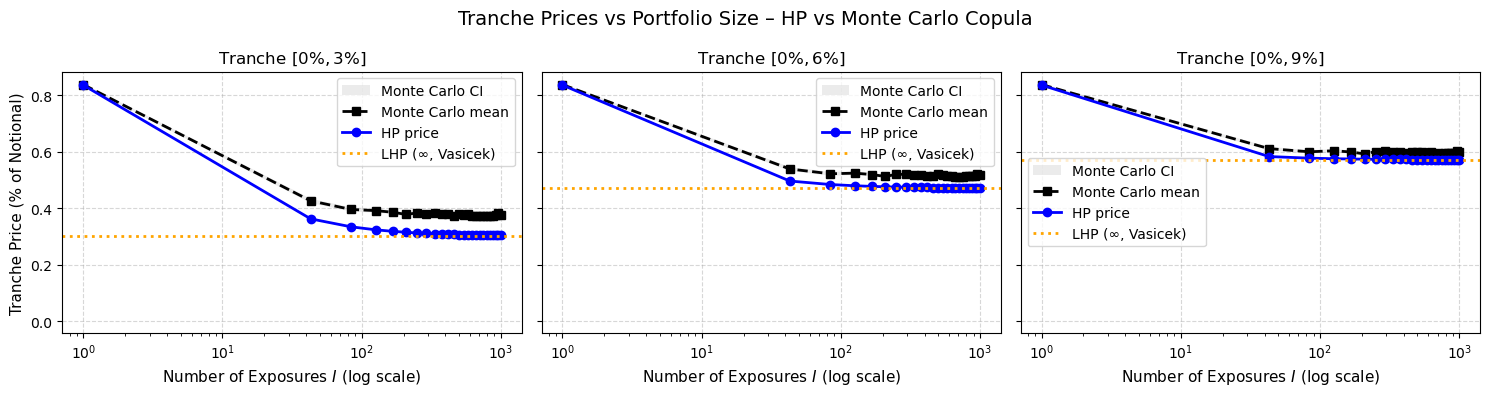

In [69]:
subplot_tranche_comparison(
    I_list,
    Ku_list[:3],
    HP_vasicek,
    prices_gauss_t,
    prices_gauss_t_up,
    prices_gauss_t_down,
    0,            # 0 = Gaussian HP, 1 = t-Student HP
    0,            # 0 = Gaussian MC, 1 = t-Student MC
    LHP_vasicek,  # New: vector of LHP prices for each tranche
    0             # New: 0 = Vasicek, 1 = t-Student
)

We notice the copula price doesn't converge to the LHP vasicek price which is completly normal because the correlation used in the copula model is the one founded in the calibration. However, the LHP Vasicek price is a good price when we use the Vasicek correlation. That's why after, we copute Gaussian Copula Price with vasicek equity correlation adn double t-student copula with LHP correlation calibrated.

## Gaussian Copula with market correlation

In [83]:
# Vasicek equity correlation
prices_gauss, prices_gauss_up, prices_gauss_down = price_tranches_over_I(
    I_list, copula_type=0,
    discount=discount, Kd=Kd_calibration, Ku_list=Ku_list,
    Nsim=10**5, rho=corr_mkt[0], recovery=recovery, pd=p, nu=4
)

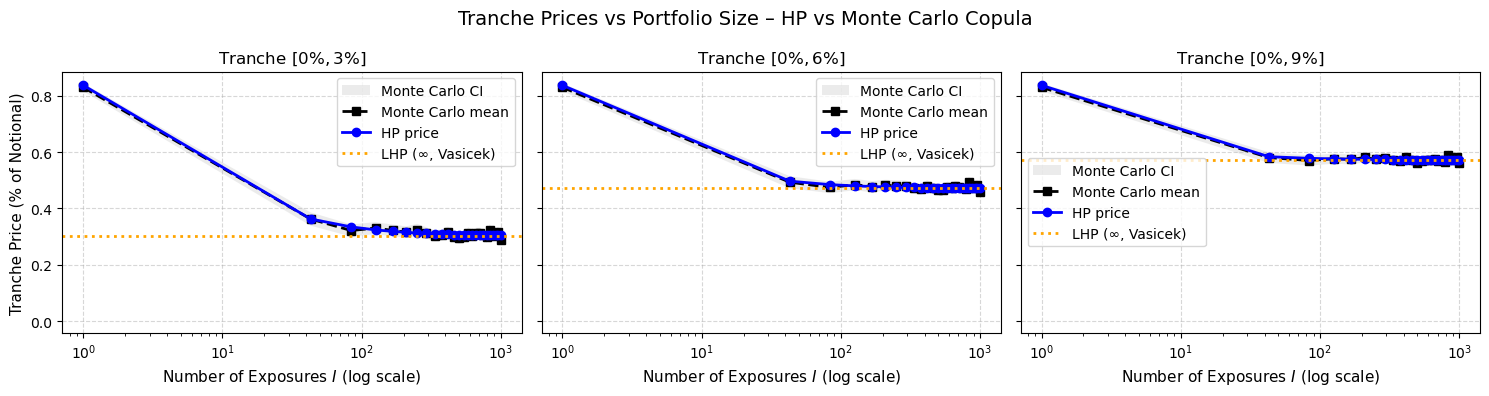

In [84]:
subplot_tranche_comparison(
    I_list,
    Ku_list[:3],
    HP_vasicek,   #HP price we compare with copula
    prices_gauss,
    prices_gauss_up,
    prices_gauss_down,
    0,            # 0 = Gaussian HP, 1 = t-Student HP
    0,            # 0 = Gaussian MC, 1 = t-Student MC
    LHP_vasicek,  # New: vector of LHP prices for each tranche
    0             # New: 0 = Vasicek, 1 = t-Student
)

Now, we see for every tranches that both HP Prices and Copula Prices look to coincide and both tends to the LHP price when I tends to + infinity. The only problem is that we don't know and can't see if the HP Price is in the incertitude interval of the monte carlo simulation. This part is treated in Matlab.

## Double-t-student Copula with t-student correlation

In [79]:
# Double-t-student with t-student correlation
prices_t, prices_t_up, prices_t_down = price_tranches_over_I(
    I_list, copula_type=1,
    discount=discount, Kd=Kd_calibration, Ku_list=Ku_list,
    Nsim=10**5, rho=rho_model, recovery=recovery, pd=p, nu=6
)

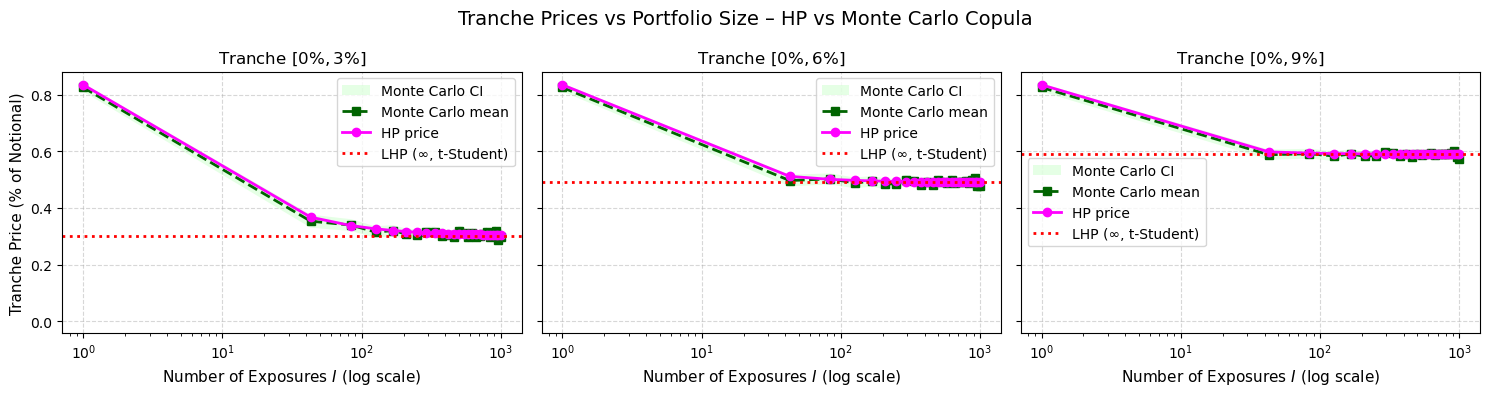

In [80]:
subplot_tranche_comparison(
    I_list,
    Ku_list[:3],
    HP_prices,   #HP price we compare with copula
    prices_t,
    prices_t_up,
    prices_t_down,
    1,            # 0 = Gaussian HP, 1 = t-Student HP
    1,            # 0 = Gaussian MC, 1 = t-Student MC
    LHP_prices,  # New: vector of LHP prices for each tranche
    1             # New: 0 = Vasicek, 1 = t-Student
)